In [668]:
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from scipy.stats import variation 
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import pickle

## Define Functions

In [2]:
from __future__ import print_function
enable_print = 0

def print(*args, **kwargs):
    if enable_print:
        return __builtins__.print(*args, **kwargs)

In [1322]:
class Region(object):
    """A region has a limited number of contractors (``NUM_CONTRACTOR``) to
    construct buildings in parallel.
    
    Buildings have to request a contractor to build their house. When they
    get one, they can start the rebuilding process and wait for it to finish
    (which takes 'cons_time' days)

    """
    def __init__(self, env, num_contractor, priority):
        self.env = env
        if priority:
            self.contractor = simpy.PriorityResource(env, num_contractor) # Priority resource
        else:
            self.contractor = simpy.Resource(env, num_contractor)

    def rebuild(self, building, cons_time):
        """The rebuilding process. It takes a ``building`` process and tries
        to rebuild it"""
        yield self.env.timeout(cons_time)
        print("{} completed rebuilding".format(building))
        
    def delay(self, building, delay_time):
        """The rebuilding process. It takes a ``building`` process and tries
        to rebuild it"""
        yield self.env.timeout(delay_time)
        print("{} completed pre-con delay".format(building))


def building(env, name, rg, damage, cons_med, delay_med, beta_cons, beta_delay, priority, data):
    """The building (each building has a ``name`` and 
    damage level 'damage') arrives at the region (``rg``) 
    and requests a rebuild.
    
    It then starts the rebuilding process, which takes a cons_time
    that is lognormally distributed. waits for it to finish and
    is reconstructured. 

    """

    if priority:  # major damage has priority, minor and moderate the same
        prio = damage
        if damage == 2:
            prio = 0
        else:
            prio = 1
#         elif damage == 0:
#             prio = 2

        print('%s arrives at the region at %.2f damage %s prio %s .' % (name, env.now, damage, prio))


        with rg.contractor.request(priority = prio) as request:
            yield request
            
            try:
                #Delay
                print('%s with damage level %s starts pre-con at %.2f.' % (name, str(damage), env.now))
                delay_cons_time = env.now
                delay_time = np.random.lognormal(np.log(delay_med[int(damage)]), beta_delay[int(damage)])

                yield env.process(rg.delay(name, delay_time))

                # Construction
                print('%s with damage level %s starts construction at %.2f.' % (name, str(damage), env.now))
                start_cons_time = env.now
                cons_time = np.random.lognormal(np.log(cons_med[int(damage)]), beta_cons)

                yield env.process(rg.rebuild(name, cons_time))

                print('%s with damage level %s finishes construction at %.2f took %.2f days' % (name,str(damage), env.now, cons_time))

                print((damage,delay_cons_time, start_cons_time, env.now))
                # Append data of construction completion
                data.append((damage,delay_cons_time, start_cons_time, env.now))
            except simpy.Interrupt as interrupt:
                
                by = interrupt.cause.by
#                 usage = env.now - interrupt.cause.usage.since
                print('%s got preempted by %s at %s' %(name, by, env.now))
    
    else:
        print('%s arrives at the region at %.2f damage %s.' % (name, env.now, damage))
        
        #Delay
        print('%s with damage level %s starts pre-con at %.2f.' % (name, str(damage), env.now))
        delay_cons_time = env.now
        delay_time = np.random.lognormal(np.log(delay_med[int(damage)]), beta_delay)

        yield env.process(rg.delay(name, delay_time))

        with rg.contractor.request() as request:
            yield request

            # Construction
            print('%s with damage level %s starts construction at %.2f.' % (name, str(damage), env.now))
            start_cons_time = env.now
            cons_time = np.random.lognormal(np.log(cons_med[int(damage)]), beta_cons)

            yield env.process(rg.rebuild(name, cons_time))

            print('%s with damage level %s finishes construction at %.2f took %.2f days' % (name,str(damage), env.now, cons_time))

            # Append data of construction times
            data.append((damage,delay_cons_time, start_cons_time, env.now))
        


def setup(env, num_contractor, damage_building, cons_med, delay_med, beta_cons, beta_delay, priority, data):
    """Create a region and number of damaged buildings"""
    # Create the region
    region = Region(env, num_contractor, priority)

    # Create buildings initially
    for i in range(len(damage_building)):
        env.process(building(env, 'Building %d' % i, region, 
                             damage_building[i], cons_med, delay_med, beta_cons, beta_delay, priority, data))
        yield env.timeout(0)

In [581]:
def count_cumsum(finish_time):
    freq = {}
    asint = [int(np.ceil(time)) for time in finish_time]
    for item in asint:
        if item in freq:
            freq[item] += 1
        else:
            freq[item] = 1

    cumsum = []
    total = 0
    for day in days:
        if day in freq:
            total += freq[day]
        else:
            total += 0

        cumsum.append(total)

    return cumsum

## Load Lombok Dataset

In [20]:
# Load Lombok dataset
total_data = pd.read_pickle('lombok_data.pkl') # includes march 2020
# region flipped
region = ['lombokbarat', 'lombokutara', 'lomboktengah', 'lomboktimur', 'sumbawabarat', 'sumbawa']

In [21]:
damage_dist = pd.DataFrame({'Mataram': [9500,3672,1345], 
                            'Lombok Barat': [45218,13556, 14069],
                            'Lombok Utara': [8889,4772, 42049], 
                           'Lombok Tengah': [16639, 3096, 4483],
                           'Lombok Timur': [12209, 4657, 10104], 
                           'Sumbawa Barat': [13078, 3803, 1283], 
                           'Sumbawa': [9652, 2756, 1374]}, 
                           index = ['rr', 'rs', 'rb'])

In [166]:
damage_dist

,Mataram,Lombok Barat,Lombok Utara,Lombok Tengah,Lombok Timur,Sumbawa Barat,Sumbawa
rr,9500,45218,8889,16639,12209,13078,9652
rs,3672,13556,4772,3096,4657,3803,2756
rb,1345,14069,42049,4483,10104,1283,1374


In [53]:
totals = pd.DataFrame()
cols = ['mataram_total_comp', 'mataram_comp_rb', 'mataram_comp_rs', 'mataram_comp_rr']
totals[cols[0]] =  total_data[cols[1:]].sum(axis = 1)
for j in range(len(region)):
    cols_new = [name.replace('mataram', region[j]) for name in cols]
    totals[cols_new[0]] =  total_data[cols_new[1:]].sum(axis = 1)

In [54]:
recovery_pct = (totals/damage_dist.sum(axis = 0).values)
recovery_pct['days'] =  recovery_pct.index - pd.to_datetime('20180819')
recovery_pct['days'] = recovery_pct['days'].dt.days

## Define Parameters

In [1611]:
CONS_MED = np.array([30,40,50]) #(minor, moderate, major)
BETA_CONS = 0.4

DELAY_MED = np.array([275,300,225]) # Median delay time (minor, moderate, major)
BETA_DELAY = np.array([0.3, 0.3, 0.3])
# BETA_DELAY = np.array([0.1, 0.1, 0.3])
damage_levels = ['Minor', 'Moderate', 'Major']


CONS_MED_hazus = np.array([125, 150, 50]) #(minor, moderate, major)
CONS_MED_hazus2 = np.array([30,40,50]) #(minor, moderate, major)
DELAY_MED_hazus = np.array([311, 314, 234]) # Median delay time (minor, moderate, major)
BETA_hazus = np.array([0.23, 0.22, 0.33])
BETA_cons = 0.4

In [1612]:
SIM_TIME = 600    # Simulation time in days
PRIORITY = True
num_sim = 10
days = np.arange(1,600)

In [1613]:
# mataram, lombokbarat, lombokutara, lomboktengah, lomboktimur, sumbawabarat, sumbawa
NUM_CONTRACTOR = [9917, 45208, 22996, 15048, 15404, 10200, 10360]
# NUM_CONTRACTOR = [10000, 45000, 25000, 15000, 15000, 10000, 10000]

In [1264]:
error_results = {}

## Mataram

In [1797]:
enable_print = 0
# NUM_CONTRACTOR = 10000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # mataram buildings: priority: major damage, minor and moderate same
    major_building =  np.ones(damage_dist.iloc[2,0])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,0]),np.ones(damage_dist.iloc[1,0])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[0], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY, PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1798]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

In [1799]:
enable_print = 1

In [1800]:
for i in range(4):
    var = np.std(complete_queue[:,i,:], axis = 0)
    print(np.min(var), np.max(var))
    print(np.nanmean(var))

0.0 0.004219572250642159
0.0016547899890542728
0.0 0.004980449311684682
0.00203507088186778
0.0 0.01139633486168367
0.00490417625459013
0.0 0.015483438727746879
0.005491831029964281


In [1801]:
np.max(var)

0.015483438727746879

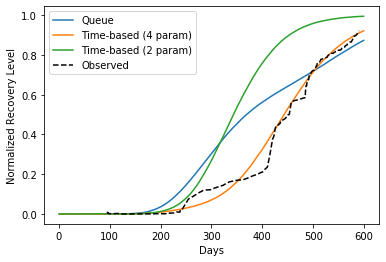

In [1802]:
plt.figure()

for i in range(num_sim):
    finish_time = [data[3] for data in data_queue[i]]
    y = np.arange(len(finish_time))/float(len(finish_time)-1)

    r_hazus = np.sort(data_hazus[i])
    y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue', color = 'tab:blue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4 param)', color = 'tab:orange')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2 param)', color = 'tab:green')
plt.plot(recovery_pct['days'], recovery_pct.iloc[:,0], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

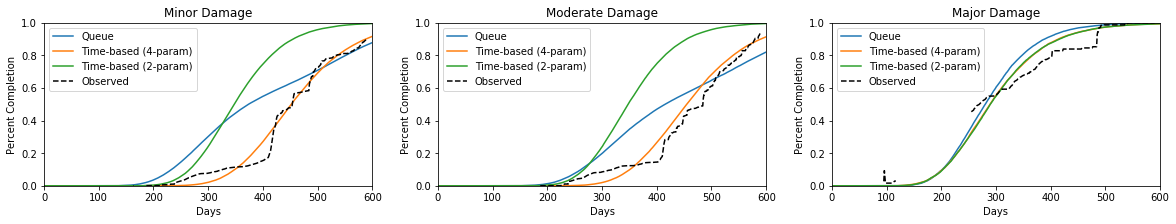

In [1803]:
names = ['mataram_comp_rr', 'mataram_target_rr', 
         'mataram_comp_rs', 'mataram_target_rs', 
         'mataram_comp_rb', 'mataram_target_rb', 'mataram']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

    for i in range(num_sim):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        y = np.arange(len(finish_time))/float(len(finish_time)-1)

        r_hazus = np.sort(data_hazus[i][damage_building == d])
        y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
    plt.ylim([0, 1])
    plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

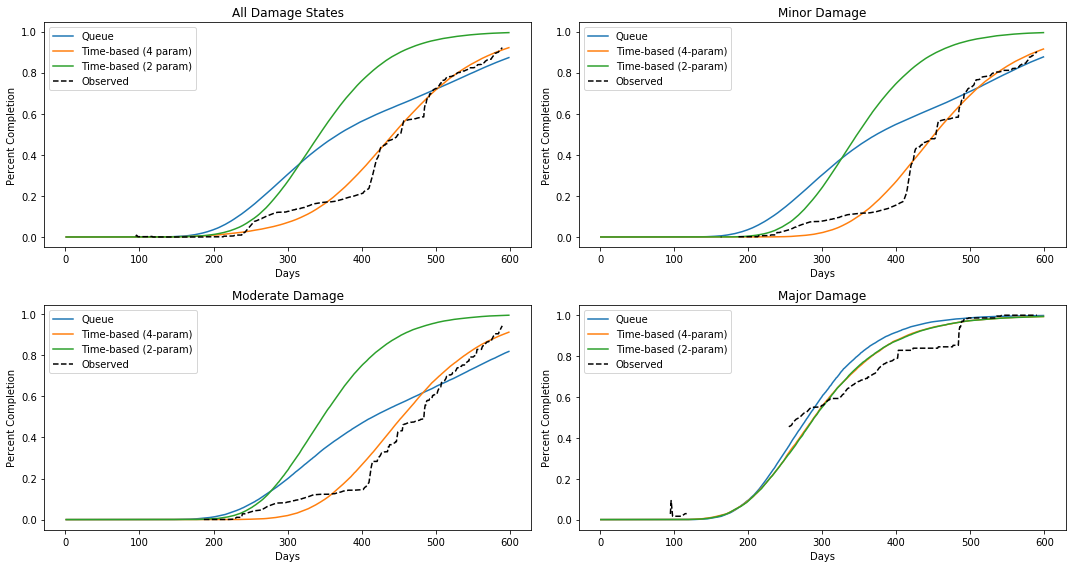

In [1804]:
plt.figure(figsize = (15,8))

plt.subplot(2,2,1)
for i in range(num_sim):
    finish_time = [data[3] for data in data_queue[i]]
    y = np.arange(len(finish_time))/float(len(finish_time)-1)

    r_hazus = np.sort(data_hazus[i])
    y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue', color = 'tab:blue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4 param)', color = 'tab:orange')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2 param)', color = 'tab:green')
plt.plot(recovery_pct['days'], recovery_pct.iloc[:,0], '--', color = 'black', label = 'Observed')
plt.xlabel('Days')
plt.ylabel('Percent Completion')
plt.title('All Damage States')
plt.legend()


for d in range(3):
    plt.subplot(2,2,d+2)

    for i in range(num_sim):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        y = np.arange(len(finish_time))/float(len(finish_time)-1)

        r_hazus = np.sort(data_hazus[i][damage_building == d])
        y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))

plt.tight_layout()    
plt.show()

In [1805]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,0],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,0],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,0],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'mataram': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.1652
RMSE HAZUS: 0.04
RMSE HAZUS2: 0.2726


In [1806]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['mataram'].extend([rmse_queue_level,rmse_hazus_level, rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.2041
RMSE HAZUS: 0.0451
RMSE HAZUS2: 0.3128
Moderate Damage:
RMSE Queue: 0.1551
RMSE HAZUS: 0.0574
RMSE HAZUS2: 0.3417
Major Damage:
RMSE Queue: 0.0919
RMSE HAZUS: 0.0682
RMSE HAZUS2: 0.0693


### Check Distribution of Queue

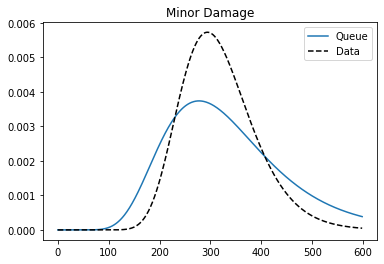

Damage Level: Minor, beta: 0.3593, median: 316.8458


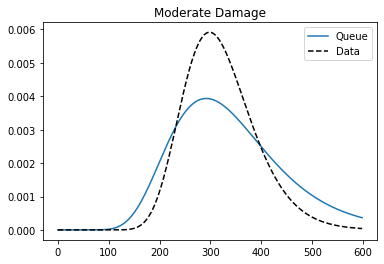

Damage Level: Moderate, beta: 0.3283, median: 325.958


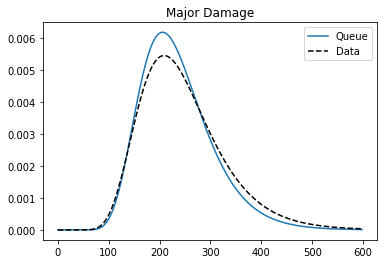

Damage Level: Major, beta: 0.2982, median: 226.1409


In [1807]:
x = np.arange(1,600)
for d in range(3):
    test = [building[2] for building in data_comp if building[0] == d]
    beta, _, med = scipy.stats.lognorm.fit(test, floc = 0)
    
    plt.figure()
    plt.plot(scipy.stats.lognorm.pdf(x, beta, loc=0, scale=med), label = 'Queue')
    plt.plot(scipy.stats.lognorm.pdf(x, BETA_hazus[d], loc=0, scale=DELAY_MED_hazus[d]), 
             color = 'black', linestyle = '--', label = 'Data')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
    plt.show()
    
    print('Damage Level: {}, beta: {}, median: {}'.format(damage_levels[d], 
                                                          np.round(beta, 4), 
                                                          np.round(med, 4)))

## Sumbawa

In [1808]:
enable_print = 0
# NUM_CONTRACTOR = 10000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # sumbawa buildings: priority: major damage, minor and moderate same
    major_building =  np.ones(damage_dist.iloc[2,-1])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,-1]),np.ones(damage_dist.iloc[1,-1])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[-1], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY, PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1809]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

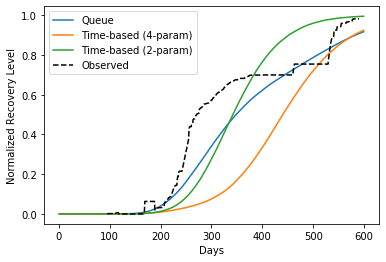

In [1810]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')    
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')    
    
plt.plot(recovery_pct['days'], recovery_pct.iloc[:,-2], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

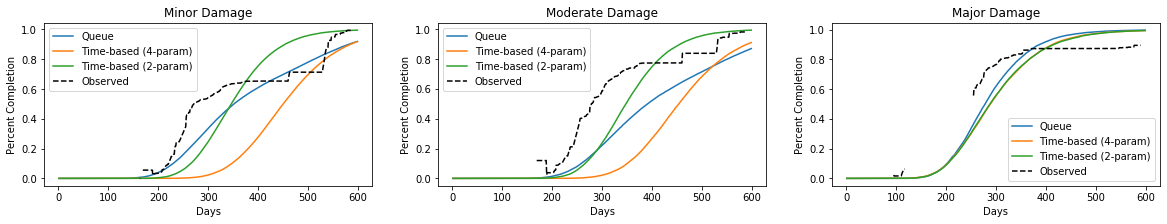

In [1811]:
names = ['sumbawa_comp_rr', 'sumbawa_target_rr', 
         'sumbawa_comp_rs', 'sumbawa_target_rs', 
         'sumbawa_comp_rb', 'sumbawa_target_rb', 'sumbawa']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

In [1812]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,-2],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,-2],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,-2],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'sumbawa': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.117
RMSE HAZUS: 0.2855
RMSE HAZUS2: 0.1646


In [1813]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['sumbawa'].extend([rmse_queue_level,rmse_hazus_level, rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.1152
RMSE HAZUS: 0.3161
RMSE HAZUS2: 0.1912
Moderate Damage:
RMSE Queue: 0.2306
RMSE HAZUS: 0.3826
RMSE HAZUS2: 0.1739
Major Damage:
RMSE Queue: 0.1096
RMSE HAZUS: 0.1268
RMSE HAZUS2: 0.1245


## Sumbawa Barat

In [1814]:
enable_print = 0
# NUM_CONTRACTOR = 10000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # sumbawa barat buildings: priority: major damage, minor and moderate same
    major_building =  np.ones(damage_dist.iloc[2,-2])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,-2]),np.ones(damage_dist.iloc[1,-2])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[-2], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY, PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)

    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1815]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

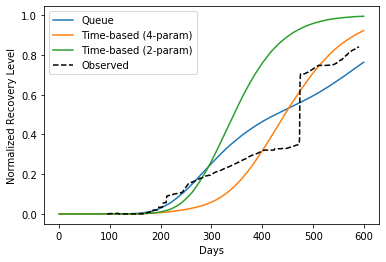

In [1816]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')   
    
plt.plot(recovery_pct['days'], recovery_pct.iloc[:,-3], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

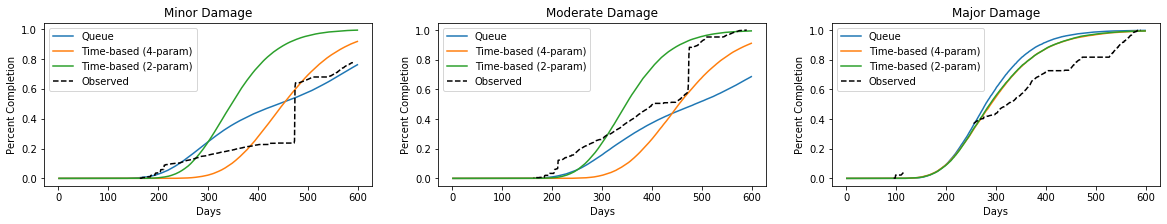

In [1818]:
names = ['sumbawabarat_comp_rr', 'sumbawabarat_target_rr', 
         'sumbawabarat_comp_rs', 'sumbawabarat_target_rs', 
         'sumbawabarat_comp_rb', 'sumbawabarat_target_rb', 'sumbawabarat']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
  
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

In [1819]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,-3],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,-3],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,-3],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'sumbawabarat': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.1095
RMSE HAZUS: 0.0973
RMSE HAZUS2: 0.278


In [1820]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['sumbawabarat'].extend([rmse_queue_level,rmse_hazus_level, rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.1438
RMSE HAZUS: 0.1269
RMSE HAZUS2: 0.3493
Moderate Damage:
RMSE Queue: 0.2213
RMSE HAZUS: 0.1925
RMSE HAZUS2: 0.1688
Major Damage:
RMSE Queue: 0.1745
RMSE HAZUS: 0.1403
RMSE HAZUS2: 0.1426


## Lombok Barat

Minor and moderate first

In [1821]:
enable_print = 0
# NUM_CONTRACTOR = 45000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # lombok barat buildings
#     minor_building =  np.zeros(damage_dist.iloc[0,1])
#     major_mod = np.concatenate((np.ones(damage_dist.iloc[2,1])*2,np.ones(damage_dist.iloc[1,1])))
#     np.random.shuffle(major_mod)
#     damage_building = np.concatenate((minor_building, major_mod))
    
    major_building =  np.ones(damage_dist.iloc[2,1])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,1]),np.ones(damage_dist.iloc[1,1])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((minor_mod, major_building))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[1], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY,  PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1822]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

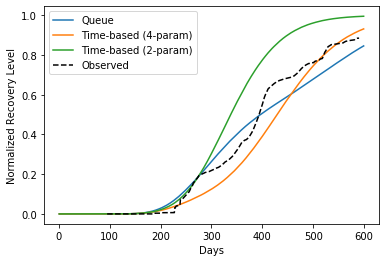

In [1823]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')

plt.plot(recovery_pct['days'], recovery_pct.iloc[:,1], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

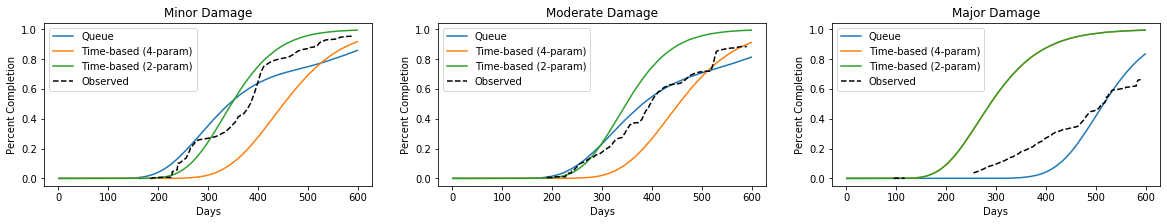

In [1825]:
names = ['lombokbarat_comp_rr', 'lombokbarat_target_rr', 
         'lombokbarat_comp_rs', 'lombokbarat_target_rs', 
         'lombokbarat_comp_rb', 'lombokbarat_target_rb', 'lombokbarat']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

In [1826]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,1],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,1],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,1],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'lombokbarat': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.0682
RMSE HAZUS: 0.0797
RMSE HAZUS2: 0.1584


In [1827]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['lombokbarat'].extend([rmse_queue_level,rmse_hazus_level,rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.1086
RMSE HAZUS: 0.2311
RMSE HAZUS2: 0.0906
Moderate Damage:
RMSE Queue: 0.0597
RMSE HAZUS: 0.1478
RMSE HAZUS2: 0.1747
Major Damage:
RMSE Queue: 0.1393
RMSE HAZUS: 0.5047
RMSE HAZUS2: 0.5053


## Major first

In [1828]:
enable_print = 0
# NUM_CONTRACTOR = 45000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # lombok barat buildings
#     minor_building =  np.zeros(damage_dist.iloc[0,1])
#     major_mod = np.concatenate((np.ones(damage_dist.iloc[2,1])*2,np.ones(damage_dist.iloc[1,1])))
#     np.random.shuffle(major_mod)
#     damage_building = np.concatenate((minor_building, major_mod))
    
    major_building =  np.ones(damage_dist.iloc[2,1])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,1]),np.ones(damage_dist.iloc[1,1])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[1], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY,  PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1829]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

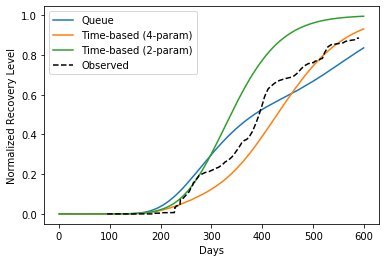

In [1830]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')

plt.plot(recovery_pct['days'], recovery_pct.iloc[:,1], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

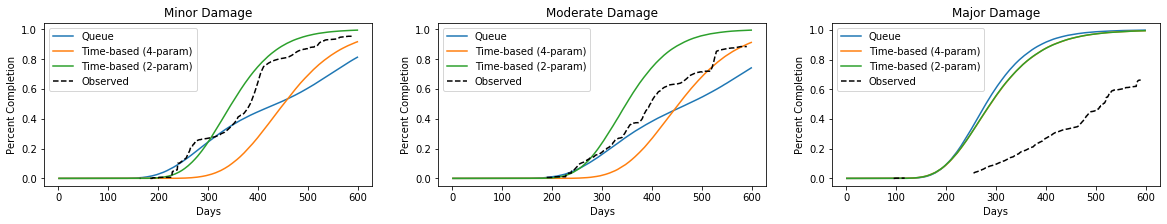

In [1831]:
names = ['lombokbarat_comp_rr', 'lombokbarat_target_rr', 
         'lombokbarat_comp_rs', 'lombokbarat_target_rs', 
         'lombokbarat_comp_rb', 'lombokbarat_target_rb', 'lombokbarat']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

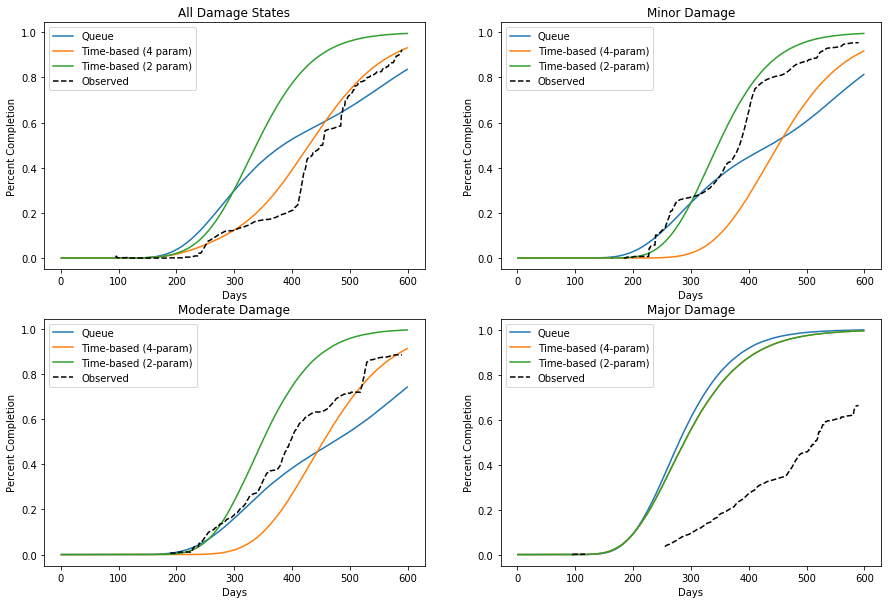

In [1832]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
for i in range(num_sim):
    finish_time = [data[3] for data in data_queue[i]]
    y = np.arange(len(finish_time))/float(len(finish_time)-1)

    r_hazus = np.sort(data_hazus[i])
    y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue', color = 'tab:blue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4 param)', color = 'tab:orange')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2 param)', color = 'tab:green')
plt.plot(recovery_pct['days'], recovery_pct.iloc[:,0], '--', color = 'black', label = 'Observed')
plt.xlabel('Days')
plt.ylabel('Percent Completion')
plt.title('All Damage States')
plt.legend()


for d in range(3):
    plt.subplot(2,2,d+2)

    for i in range(num_sim):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        y = np.arange(len(finish_time))/float(len(finish_time)-1)

        r_hazus = np.sort(data_hazus[i][damage_building == d])
        y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))

plt.show()

## Lombok Utara

In [1833]:
enable_print = 0
# NUM_CONTRACTOR = 25000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # lombok utara buildings: priority: major damage, minor and moderate same

    major_building =  np.ones(damage_dist.iloc[2,2])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,2]),np.ones(damage_dist.iloc[1,2])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[2], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY, PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1834]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

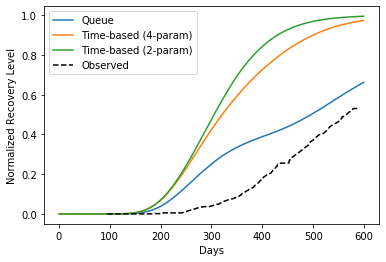

In [1835]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')

plt.plot(recovery_pct['days'], recovery_pct.iloc[:,2], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

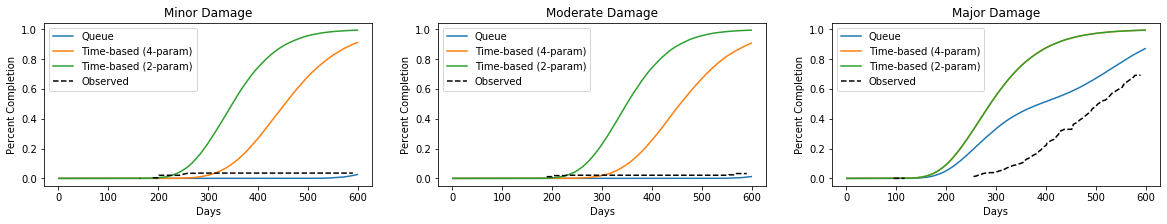

In [1836]:
names = ['lombokutara_comp_rr', 'lombokutara_target_rr', 
         'lombokutara_comp_rs', 'lombokutara_target_rs', 
         'lombokutara_comp_rb', 'lombokutara_target_rb', 'lombokutara']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

In [1837]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,2],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,2],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,2],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'lombokutara': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.1574
RMSE HAZUS: 0.4226
RMSE HAZUS2: 0.4887


In [1838]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['lombokutara'].extend([rmse_queue_level,rmse_hazus_level,rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.0324
RMSE HAZUS: 0.449
RMSE HAZUS2: 0.6799
Moderate Damage:
RMSE Queue: 0.0212
RMSE HAZUS: 0.4518
RMSE HAZUS2: 0.6924
Major Damage:
RMSE Queue: 0.2467
RMSE HAZUS: 0.5265
RMSE HAZUS2: 0.5263


## Lombok Timur

In [1839]:
enable_print = 0
# NUM_CONTRACTOR = 15000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # lombok timur buildings: priority: major damage, minor and moderate same

    major_building =  np.ones(damage_dist.iloc[2,4])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,4]),np.ones(damage_dist.iloc[1,4])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[4], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY,  PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1840]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

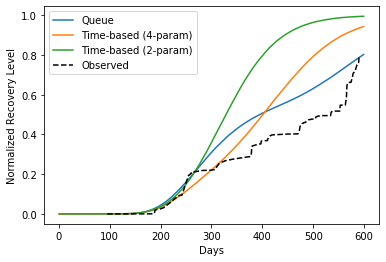

In [1841]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')

plt.plot(recovery_pct['days'], recovery_pct.iloc[:,4], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

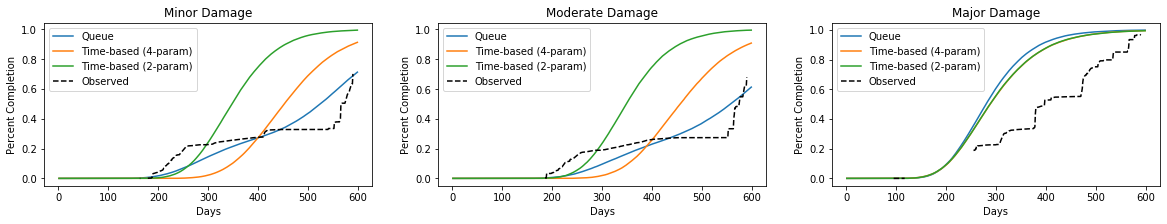

In [1842]:
names = ['lomboktimur_comp_rr', 'lomboktimur_target_rr', 
         'lomboktimur_comp_rs', 'lomboktimur_target_rs', 
         'lomboktimur_comp_rb', 'lomboktimur_target_rb', 'lomboktimur']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')
    
    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

In [1843]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,4],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,4],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,4],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'lomboktimur': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.1205
RMSE HAZUS: 0.1883
RMSE HAZUS2: 0.3368


In [1844]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['lomboktimur'].extend([rmse_queue_level,rmse_hazus_level, rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.0978
RMSE HAZUS: 0.2485
RMSE HAZUS2: 0.4276
Moderate Damage:
RMSE Queue: 0.0886
RMSE HAZUS: 0.2648
RMSE HAZUS2: 0.4671
Major Damage:
RMSE Queue: 0.3378
RMSE HAZUS: 0.3048
RMSE HAZUS2: 0.3057


## Lombok Tengah

In [1845]:
enable_print = 0
# NUM_CONTRACTOR = 15000  # Number of contractor available
data_queue = []
data_hazus = []
data_hazus2 = []

for k in tqdm(range(num_sim)):
    data_comp = []
    
    # lombok tengah buildings: priority: major damage, minor and moderate same
    major_building =  np.ones(damage_dist.iloc[2,3])*2
    minor_mod = np.concatenate((np.zeros(damage_dist.iloc[0,3]),np.ones(damage_dist.iloc[1,3])))
    np.random.shuffle(minor_mod)
    damage_building = np.concatenate((major_building, minor_mod))

    ## QUEUE
    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_CONTRACTOR[3], damage_building, CONS_MED, DELAY_MED, BETA_CONS, BETA_DELAY,  PRIORITY, data_comp))

    # Execute!
    env.run(until=SIM_TIME)
    
    # Calculate recovery curve
    data_queue.append(data_comp)
    
    ## HAZUS   
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus.append(r)
    
    ## HAZUS (government param) 
    delay = np.random.lognormal(np.log(DELAY_MED_hazus[damage_building.astype(int)]), BETA_hazus[damage_building.astype(int)])
    cons = np.random.lognormal(np.log(CONS_MED_hazus2[damage_building.astype(int)]), BETA_cons)
    r = delay + cons
    data_hazus2.append(r)
            
# region_recov_queue.append(recov_queue)
# region_recov_hazus.append(recov_hazus)

In [1846]:
complete_queue = np.zeros((num_sim, 4, len(days)))
complete_hazus = np.zeros((num_sim, 4, len(days)))
complete_hazus2 = np.zeros((num_sim, 4, len(days)))

for i in tqdm(range(num_sim)):
    finish_time = [data[3] for data in data_queue[i]]
    r_hazus = np.sort(data_hazus[i])
    r_hazus2 = np.sort(data_hazus2[i])
    
    complete_queue[i,0,:] = np.array(count_cumsum(finish_time))/len(damage_building)
    complete_hazus[i,0,:] = np.array(count_cumsum(r_hazus))/len(damage_building)
    complete_hazus2[i,0,:] = np.array(count_cumsum(r_hazus2))/len(damage_building)
    
    for d in range(3):
        finish_time = [data[3] for data in data_queue[i] if data[0] == d]
        r_hazus = np.sort(data_hazus[i][damage_building == d])
        r_hazus2 = np.sort(data_hazus2[i][damage_building == d])
        
        complete_queue[i,d+1,:] = np.array(count_cumsum(finish_time))/len(damage_building[damage_building == d])
        complete_hazus[i,d+1,:] = np.array(count_cumsum(r_hazus))/len(damage_building[damage_building == d])
        complete_hazus2[i,d+1,:] = np.array(count_cumsum(r_hazus2))/len(damage_building[damage_building == d])
    
mean_queue = np.mean(complete_queue, axis = 0)
mean_hazus = np.mean(complete_hazus, axis = 0)
mean_hazus2 = np.mean(complete_hazus2, axis = 0)

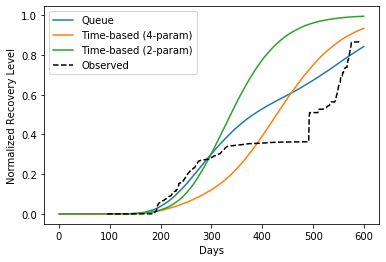

In [1847]:
plt.figure()

# for i in range(num_sim):
#     finish_time = [data[3] for data in data_queue[i]]
#     y = np.arange(len(finish_time))/float(len(finish_time)-1)

#     r_hazus = np.sort(data_hazus[i])
#     y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#     plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#     plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

plt.plot(days, mean_queue[0,:], label = 'Queue')
plt.plot(days, mean_hazus[0,:], label = 'Time-based (4-param)')
plt.plot(days, mean_hazus2[0,:], label = 'Time-based (2-param)')

plt.plot(recovery_pct['days'], recovery_pct.iloc[:,3], '--', color = 'black', label = 'Observed')
# plt.ylim([0, 1])
# plt.xlim([0, 600])
plt.xlabel('Days')
plt.ylabel('Normalized Recovery Level')
plt.legend()
plt.show()

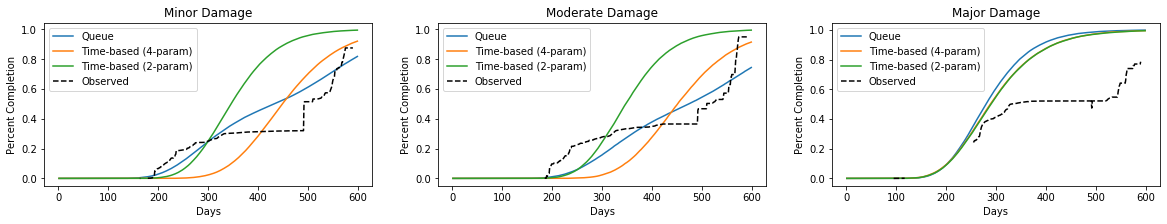

In [1848]:
names = ['lomboktengah_comp_rr', 'lomboktengah_target_rr', 
         'lomboktengah_comp_rs', 'lomboktengah_target_rs', 
         'lomboktengah_comp_rb', 'lomboktengah_target_rb', 'lomboktengah']

plt.figure(figsize = (20,3))

for d in range(3):
    plt.subplot(1,3,d+1)

#     for i in range(num_sim):
#         finish_time = [data[3] for data in data_queue[i] if data[0] == d]
#         y = np.arange(len(finish_time))/float(len(finish_time)-1)

#         r_hazus = np.sort(data_hazus[i][damage_building == d])
#         y_hazus = np.arange(len(r_hazus))/float(len(r_hazus)-1)

#         plt.step(finish_time, y_hazus[:len(finish_time)], label = 'Queue', color = 'tab:blue', alpha = 0.5)
#         plt.step(r_hazus, y_hazus, label = 'HAZUS',  color = 'tab:orange', alpha = 0.5)

    plt.plot(days, mean_queue[d+1,:], label = 'Queue')
    plt.plot(days, mean_hazus[d+1,:], label = 'Time-based (4-param)')
    plt.plot(days, mean_hazus2[d+1,:], label = 'Time-based (2-param)')

    observed = total_data[names[d*2]]/total_data[names[d*2+1]][-1]
    plt.plot(recovery_pct['days'], observed, '--', color = 'black', label = 'Observed')
    
#     plt.ylim([0, 1])
#     plt.xlim([0, 600])
    plt.xlabel('Days')
    plt.ylabel('Percent Completion')
    plt.legend()
    plt.title('{} Damage'.format(damage_levels[d]))
plt.show()

In [1849]:
# Compute error and confidence bounds
enable_print = 1
idx = recovery_pct['days'].values-1
rmse_queue = np.sqrt(mean_squared_error(recovery_pct.iloc[:,3],mean_queue[0,idx]))
rmse_hazus = np.sqrt(mean_squared_error(recovery_pct.iloc[:,3],mean_hazus[0,idx]))
rmse_hazus2 = np.sqrt(mean_squared_error(recovery_pct.iloc[:,3],mean_hazus2[0,idx]))

print('Overall Recovery:')
print('RMSE Queue: {}'.format(str(np.round(rmse_queue,4))))
print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus,4))))
print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus2,4))))

error_results.update({'lomboktengah': [rmse_queue, rmse_hazus, rmse_hazus2]})

Overall Recovery:
RMSE Queue: 0.1336
RMSE HAZUS: 0.1636
RMSE HAZUS2: 0.3157


In [1850]:
enable_print = 1

for i in range(3):
    observed = total_data[names[i*2]]/total_data[names[i*2+1]][-1]
    idx = observed.notnull()
    days_idx = recovery_pct['days'].loc[idx]-1
    rmse_queue_level = np.sqrt(mean_squared_error(observed[idx],mean_queue[i+1,days_idx]))

    rmse_hazus_level = np.sqrt(mean_squared_error(observed[idx],mean_hazus[i+1,days_idx]))
    rmse_hazus_level2 = np.sqrt(mean_squared_error(observed[idx],mean_hazus2[i+1,days_idx]))
    
    print('{} Damage:'.format(damage_levels[i]))
    print('RMSE Queue: {}'.format(str(np.round(rmse_queue_level,4))))
    print('RMSE HAZUS: {}'.format(str(np.round(rmse_hazus_level,4))))
    print('RMSE HAZUS2: {}'.format(str(np.round(rmse_hazus_level2,4))))
    
    error_results['lomboktengah'].extend([rmse_queue_level,rmse_hazus_level, rmse_hazus_level2])

Minor Damage:
RMSE Queue: 0.1201
RMSE HAZUS: 0.1802
RMSE HAZUS2: 0.3511
Moderate Damage:
RMSE Queue: 0.1065
RMSE HAZUS: 0.1918
RMSE HAZUS2: 0.3423
Major Damage:
RMSE Queue: 0.3547
RMSE HAZUS: 0.3292
RMSE HAZUS2: 0.3278


## Summary of Error

In [1708]:
error = pd.DataFrame(error_results)
error['average'] = error.mean(axis = 1)
row_name = ['overall_queue', 'overall_hazus','overall_hazus2',
           'minor_queue', 'minor_hazus', 'minor_hazus2',
           'moderate_queue', 'moderate_hazus', 'moderate_hazus2',
           'major_queue', 'major_hazus', 'major_hazus2']
error.index = row_name
error

,mataram,sumbawa,sumbawabarat,lombokbarat,lombokutara,lomboktimur,lomboktengah,average
overall_queue,0.164153,0.117868,0.109829,0.067865,0.157684,0.121083,0.133692,0.124596
overall_hazus,0.039332,0.284688,0.097252,0.079842,0.422197,0.188710,0.162797,0.182117
overall_hazus2,0.273818,0.164771,0.278550,0.158418,0.488709,0.336935,0.316176,0.288197
minor_queue,0.202327,0.115399,0.143664,0.108632,0.032444,0.098384,0.120018,0.117267
minor_hazus,0.045715,0.315676,0.126095,0.231660,0.448232,0.248460,0.179344,0.227883
minor_hazus2,0.314700,0.191136,0.350044,0.090315,0.679714,0.428424,0.351706,0.343720
moderate_queue,0.154283,0.232485,0.216429,0.059035,0.021205,0.087034,0.106999,0.125353
moderate_hazus,0.053965,0.379735,0.191312,0.146940,0.451657,0.266438,0.192315,0.240338
moderate_hazus2,0.340915,0.174191,0.168882,0.175452,0.691151,0.466856,0.343471,0.337274
major_queue,0.094626,0.114375,0.176115,0.139649,0.247224,0.339029,0.355116,0.209448


In [1709]:
# Overall error
overall = ((error.loc['overall_hazus', 'average'] - error.loc['overall_queue', 'average'])/
           error.loc['overall_hazus', 'average'])

# Minor
minor_error = ((error.loc['minor_hazus', 'average'] - error.loc['minor_queue', 'average'])/
               error.loc['minor_hazus', 'average'])

# Moderate
moderate_error = ((error.loc['moderate_hazus', 'average'] - error.loc['moderate_queue', 'average'])/
                  error.loc['moderate_hazus', 'average'])

#Major
major_error = ((error.loc['major_hazus', 'average'] - error.loc['major_queue', 'average'])/
               error.loc['major_hazus', 'average'])

In [1710]:
enable_print = 1
print('Overall Error:', np.round(overall,4))
print('Minor Error:' , np.round(minor_error,4))
print('Moderate Error:', np.round(moderate_error,4))
print('Major Error:', np.round(major_error,4))

Overall Error: 0.3158
Minor Error: 0.4854
Moderate Error: 0.4784
Major Error: 0.2673


In [1711]:
# Overall error
overall = ((error.loc['overall_hazus2', 'average'] - error.loc['overall_queue', 'average'])/
           error.loc['overall_hazus2', 'average'])

# Minor
minor_error = ((error.loc['minor_hazus2', 'average'] - error.loc['minor_queue', 'average'])/
               error.loc['minor_hazus2', 'average'])

# Moderate
moderate_error = ((error.loc['moderate_hazus2', 'average'] - error.loc['moderate_queue', 'average'])/
                  error.loc['moderate_hazus2', 'average'])

#Major
major_error = ((error.loc['major_hazus2', 'average'] - error.loc['major_queue', 'average'])/
               error.loc['major_hazus2', 'average'])

In [1712]:
enable_print = 1
print('Overall Error:', np.round(overall,4))
print('Minor Error:' , np.round(minor_error,4))
print('Moderate Error:', np.round(moderate_error,4))
print('Major Error:', np.round(major_error,4))

Overall Error: 0.5677
Minor Error: 0.6588
Moderate Error: 0.6283
Major Error: 0.2676
